In [11]:
# import sys, os
# !{sys.executable} -m pip install --quiet --user -r requirements.txt

# Import parent package
# - https://stackoverflow.com/questions/1054271/how-to-import-a-python-class-that-is-in-a-directory-above
# - https://www.datasciencelearner.com/importerror-attempted-relative-import-parent-package/
# import sys, os
# path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'cryptowatsonindicators')))
# if (not (path2add in sys.path)) :
#     sys.path.append(path2add)

# parent_dir_path = os.chdir('..')
# if (not (parent_dir_path in sys.path)):
#     sys.path.append(parent_dir_path)
from cryptowatsonindicators import rwa
import requests
requests.packages.urllib3.disable_warnings()

['/Users/raultruco/source/crypto/cryptowatson/cryptowatson-indicators/simulators', '/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/raultruco/source/crypto/cryptowatson/cryptowatson-trader-bot/venv/lib/python3.9/site-packages', '..', '..', None]


### API key variables

In [6]:
binance_api_key = ''
binance_secret_key = ''

### Simulator variables

In [7]:
# time_frame = "day"
ticker_symbol = "BTCUSDT"    # currently only works with Bitcoin
weight_type = "fibs"   # "fibs" or "originaldca"
# dcaAmount = 100

### Plot Rainbow chart

Error reading csv file btcusdt_1d_nasdaq.csv: [Errno 2] No such file or directory: 'btcusdt_1d_nasdaq.csv'


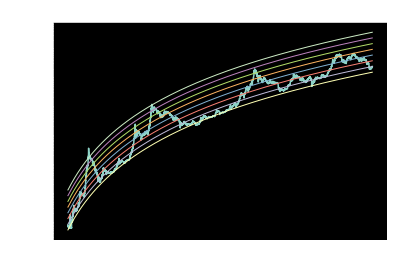

In [8]:
rwa.plot_rainbow()

### Run simulator!

In [5]:
rwa.rwa_calculations(binance_api_key, binance_secret_key, ticker_symbol, weight_type)

<class 'float'>
23594.5612527139
Bitcoins price falls between $ 23594.5612527139 and $ 37189.119430892795  therefore our multiplier is  1.3
